In [65]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense,Dropout, Flatten,LSTM,RepeatVector,TimeDistributed,Conv1D,MaxPooling1D
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from livelossplot.keras import PlotLossesCallback

from statsmodels.tsa.seasonal import seasonal_decompose

In [66]:
df = pd.read_csv("elecequip.csv")
df.head()

,x
0,79.35
1,75.78
2,86.32
3,72.60
4,74.86


# Data Preparation

For simplicity, we consider fixed length sequences at training time. We use the past 24 months to forecast the following 12 months.

In [67]:
def train_test_builder(df,size_test=24,length_train_sequence = 24,length_forecast = 12, normalize = False):
    
    train_df = df[:-size_test]    
    
    # create training sets
    train_x,train_y = window_splitter(train_df)
    
    # create test set
    tmp = df[:length_forecast]
    tmp = pd.concat([df,tmp],ignore_index = True)
    tmp[-length_forecast:] = np.nan  # unknown
    test_x,test_y = window_splitter(tmp)
    # drop elements in training
    test_x = test_x[train_x.shape[0]:]
    test_y = test_y[train_x.shape[0]:]
    for i in range(length_forecast):
        test_y[i,:(11-i)]=np.nan # present in training_set
    
    # normalize
    if normalize:
        m = train_df.x.mean()
        sd = train_df.x.std()
        train_x -= m
        train_x/= sd
        test_x -=m
        test_x /= sd
    
    return train_x,train_y,test_x,test_y


# iterate over the time steps and divide the data into overlapping windows; 
def window_splitter(train_df,length_train_sequence = 24,length_forecast = 12):
    i = 0
    x,y = [],[]
    while i + length_train_sequence+ length_forecast < len(train_df):
        x.append(train_df.x[i:(i+length_train_sequence)].values)
        y.append(train_df.x[(i+length_train_sequence):(i+length_train_sequence+length_forecast)].values)
        i+=1

    x = np.array(x).reshape(-1,length_train_sequence,1)
    y = np.array(y).reshape(-1,length_forecast)
    
    return x,y

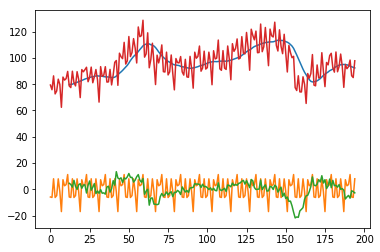

In [68]:
# a naive seasonal decomposition
series = df.x.values
result = seasonal_decompose(series, model='additive',freq=12,two_sided = False,)
plt.plot(result.trend)
plt.plot(result.seasonal)
plt.plot(result.resid)
plt.plot(result.observed)

In [69]:
deseasonalised_df = pd.DataFrame({'x':result.trend[12:]+result.resid[12:]})
deseasonalised_df.head()

,x
0,84.399820
1,83.526148
2,81.768284
3,87.421645
4,83.383950


In [70]:
# build both versions
des_train_x,des_train_y,des_test_x, _ = train_test_builder(deseasonalised_df)
train_x,train_y,test_x,test_y = train_test_builder(df)

train_x.shape, train_y.shape, test_x.shape, test_y.shape

((135, 24, 1), (135, 12), (36, 24, 1), (36, 12))

# Evaluation

In [71]:
# evaluation function
def evaluate_predictions(pred_y, test_y):
    return pd.DataFrame(abs(test_y-pred_y)).mean(skipna = True)


def plot_evaluation(pred_y,test_y,n=12):
    scores = evaluate_predictions(pred_y,test_y)

    print("Mean absolute error test set:",scores.mean())

    plt.figure(figsize=(6,4))
    plt.plot(np.arange(1,13),scores)
    plt.xticks(np.arange(1,13))
    plt.xlabel("horizon [months]", size = 15)
    plt.ylabel("MAE", size = 15)
    plt.title("Scores LSTM on test set")
    plt.show()

    plt.figure(figsize=(6,4))
    plt.title("LSTM forecasting - test set window")
    plt.plot(np.arange(1,13),pred_y[n:(n+1)].reshape(-1,1),label = "predictions")
    plt.plot(np.arange(1,13),test_y[n:(n+1)].reshape(-1,1),label = "true values")
    plt.xticks(np.arange(1,13))
    plt.xlabel("horizon [months]", size = 15)
    plt.legend()
    plt.show()

# LSTM 

In [72]:
n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]

# define model
model = Sequential()
model.add(LSTM(256, activation='relu', input_shape=(None, 1)))
model.add(Dropout(0.1))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(n_outputs))

# compile
model.compile(loss='mse', optimizer= Adam(lr=1e-3), metrics = ["mae"])

# callbacks
early_stopping = EarlyStopping(patience=32, monitor='val_loss', mode='auto', restore_best_weights=True)
callbacks=[PlotLossesCallback(), early_stopping]

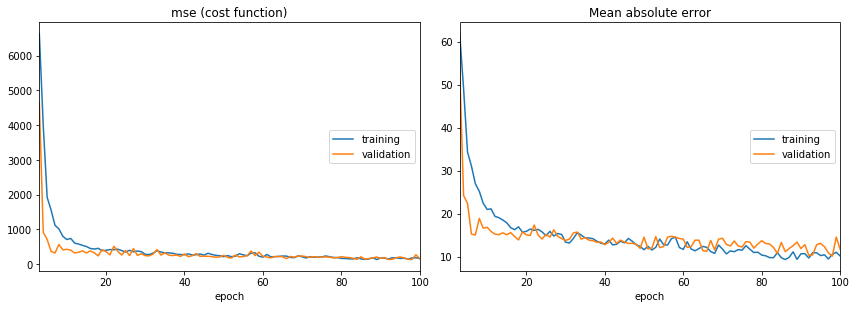

mse (cost function):
training   (min:  135.955, max: 8658.680, cur:  161.941)
validation (min:  135.222, max: 15948.557, cur:  158.111)

Mean absolute error:
training   (min:    9.313, max:   80.290, cur:   10.140)
validation (min:   10.081, max:  107.065, cur:   11.699)


In [73]:
# fit network
model.fit(des_train_x, des_train_y, 
          validation_split = 0.2, 
          epochs=100, 
          shuffle = True,
          batch_size=16,
          verbose=1,
          callbacks = callbacks,
         )

In [74]:
# predict test set
pred_y = model.predict(des_test_x)
# add seasonality of the past year
for i in np.arange(pred_y.shape[0]-1,-1,-1):
    pred_y[pred_y.shape[0]-1-i] += result.seasonal[-(13+i):-(1+i)]

Mean absolute error test set: 6.996358988444009


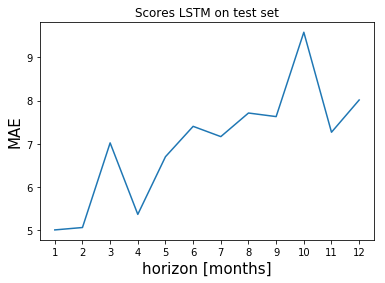

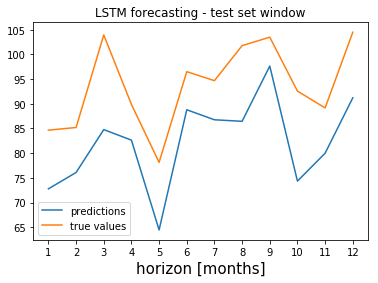

In [75]:
plot_evaluation(pred_y,test_y,n=12)

In [80]:
# store predictions on test set
tmp = pd.DataFrame(test_y-pred_y)
tmp.columns = np.arange(1,13)

tmp.to_csv("lstm_predictions.csv",index = False)

# Encoder Decoder

In [59]:
n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]

des_train_y = des_train_y.reshape((des_train_y.shape[0], des_train_y.shape[1], 1))
# define model
model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=(n_timesteps, n_features)))
model.add(Dropout(0.1))
model.add(RepeatVector(n_outputs))
model.add(LSTM(128, activation='relu', return_sequences=True))
model.add(Dropout(0.1))
model.add(TimeDistributed(Dense(64, activation='relu')))
model.add(Dropout(0.1))
model.add(TimeDistributed(Dense(1)))

# compile
model.compile(loss='mse', optimizer= Adam(lr=1e-3), metrics = ["mae"])

# callbacks
early_stopping = EarlyStopping(patience=16, monitor='val_loss', mode='auto', restore_best_weights=True)
callbacks=[PlotLossesCallback(), early_stopping]

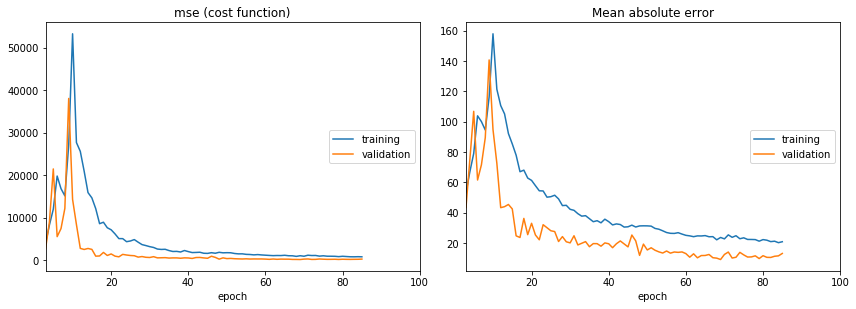

mse (cost function):
training   (min:  749.605, max: 53275.666, cur:  749.605)
validation (min:  112.561, max: 38046.211, cur:  213.366)

Mean absolute error:
training   (min:   20.126, max:  157.998, cur:   20.750)
validation (min:    9.008, max:  140.734, cur:   13.010)


In [60]:
# fit network
model.fit(des_train_x, des_train_y, 
          validation_split = 0.1, 
          epochs=100, 
          shuffle = True,
          batch_size=16,
          verbose=1,
          callbacks = callbacks,
         )

Mean absolute error test set: 19.8356235555013


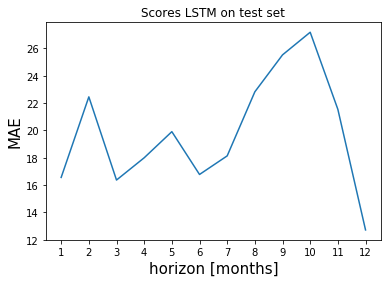

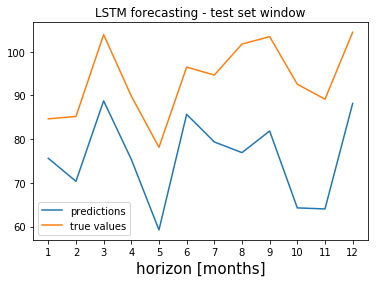

In [61]:
# predict test set
pred_y = model.predict(des_test_x).reshape(-1,12)
# add seasonality of the past year
for i in np.arange(pred_y.shape[0]-1,-1,-1):
    pred_y[pred_y.shape[0]-1-i] += result.seasonal[-(13+i):-(1+i)]

plot_evaluation(pred_y,test_y,n=12)

# Encoder decoder CNN LSTM

In [62]:
n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]

des_train_y = des_train_y.reshape((des_train_y.shape[0], des_train_y.shape[1], 1))
# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.1))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(RepeatVector(n_outputs))
model.add(LSTM(128, activation='relu', return_sequences=True))
model.add(Dropout(0.1))
model.add(TimeDistributed(Dense(64, activation='relu')))
model.add(TimeDistributed(Dense(1)))
# compile
model.compile(loss='mse', optimizer= Adam(lr=1e-3), metrics = ["mae"])

# callbacks
early_stopping = EarlyStopping(patience=16, monitor='val_loss', mode='auto', restore_best_weights=True)
callbacks=[PlotLossesCallback(), early_stopping]

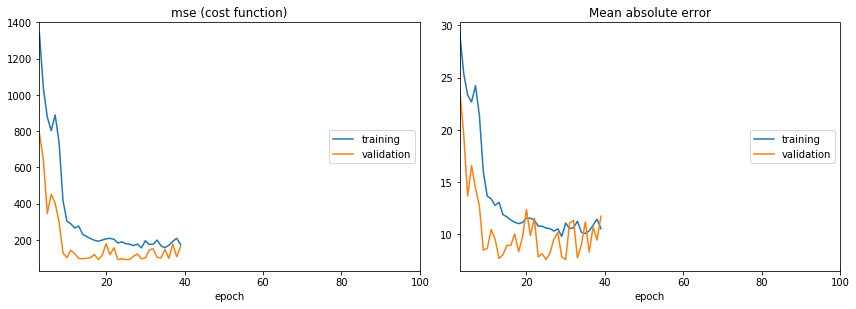

mse (cost function):
training   (min:  156.104, max: 3557.245, cur:  173.765)
validation (min:   92.170, max: 1959.028, cur:  164.493)

Mean absolute error:
training   (min:    9.808, max:   50.099, cur:   10.548)
validation (min:    7.599, max:   36.103, cur:   11.747)


In [63]:
# fit network
model.fit(des_train_x, des_train_y, 
          validation_split = 0.1, 
          epochs=100, 
          shuffle = True,
          batch_size=16,
          verbose=1,
          callbacks = callbacks,
         )

Mean absolute error test set: 22.237042746988934


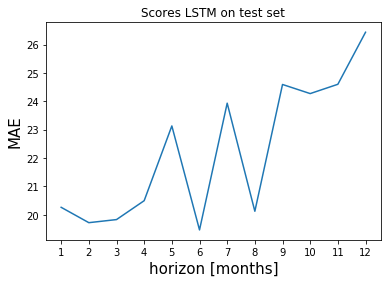

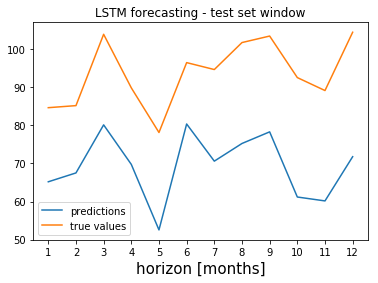

In [64]:
# predict test set
pred_y = model.predict(des_test_x).reshape(-1,12)
# add seasonality of the past year
for i in np.arange(pred_y.shape[0]-1,-1,-1):
    pred_y[pred_y.shape[0]-1-i] += result.seasonal[-(13+i):-(1+i)]

plot_evaluation(pred_y,test_y,n=12)